In [1]:
import numpy as np
import pandas as pd
import math
from itertools import count
from tqdm.auto import tqdm
import threading
import os, platform
import multiprocessing
import subprocess
from queue import Empty as QueueEmpty
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [41]:
model_list_name, output_dir = 'models_mcc200', 'results_mcc200'
# model_list_name, output_dir = 'models_mcc200quick', 'results_mcc200quick'
# model_list_name, output_dir = 'models_random', 'results_random'
max_time = 5 # 5
n_parallel = 2 # 8
run_all = False # run all tests or only those that don't have the .log file

In [42]:
# Load models and benchmark definition
model_list = open(model_list_name+'.txt', 'r').readlines()
model_list = [ f.replace('\n', '') for f in model_list ]
model_list = [ f for f in model_list if len(f) > 0 ]
# model_list = model_list[:10]
print(len(model_list))
os.makedirs(output_dir, exist_ok=True)

200


In [43]:
def run_commands(queue, pin, pbar):
    while True:
        try:
            qe = queue.get()#block=False)
            if qe is None:
                break
            # print(qe)
            tool, test_name, args, model_fname = qe
            model_basename = model_fname.split('/')[-1]
            logfile = f'{output_dir}/{model_basename}-{test_name}.log'
            # os.remove(logfile)
            if run_all or not os.path.exists(logfile):
                # print(logfile)
                with open(logfile, 'w') as f:
                    print('****************', file=f)
                    print(f'MODEL={model_fname}\n', file=f)
                    f.flush()
                    if platform.system()=='Darwin':
                        cmd = f'gtimeout {max_time}s '
                    else:
                        cmd = f'/usr/bin/time --verbose /usr/bin/timeout {max_time}s taskset -c {2*pin} ' 
                    # cmd = ''
                    if tool=='sym':
                        cmd += f'../build/sym_hilbert -c -p -u {model_fname} {args} '
                    elif tool=='4ti2':
                        cmd += f'{args} {model_fname} '
                
                    try:
                        proc = subprocess.run(cmd, shell=True, stdout=f, stderr=f)
                        exitcode = proc.returncode
                    except subprocess.TimeoutExpired:
                        exitcode = 124  # timeout

                # append exit status to the log file
                with open(logfile, 'a') as f:
                    print(f'\nEXITCODE={exitcode}\n', file=f)

                if exitcode not in [0,124]:
                    print(qe, f'EXITCODE={exitcode}')
            pbar.update(1)
        except QueueEmpty:
            print('queue empty')
            break # no more commands
    # print(f'Thread {pin} ends.')

In [44]:
tests = [
    # # [ "sym",  'TestKerA',    '' ],
    # ######### Hilbert basis #########
    # [ "4ti2", "Hil_4ti2",  "/home/elvio/4ti2/src/zsolve/hilbert" ],
    # [ "sym",  'Hil_Ga',    '-ye -nl' ],
    # [ "sym",  'Hil_GL',    '-ye -yl' ],
    # [ "sym",  'Hil_na',    '-ne -nl' ],
    # [ "sym",  'Hil_nL',    '-ne -yl' ],
    # [ "sym",  'Hil_nLH',    '-ne -yl -hg' ],
    # [ "sym",  'Hil_LD',    '-ne -yl -yd' ],
    # # [ "sym",  'Hil_nP',    '-ne -yl -po' ],
    # [ "sym",  'Hil_LS',    '-ne -yl -s' ],
    # # [ "sym",  'Hil_LZ',    '-ne -yl -z' ],
    # # [ "sym",  'Hil_LZD',   '-ne -yl -z -yd' ],
    # # [ "sym",  'Hil_LZS',   '-ne -yl -z -yd -s' ],
    # [ "sym",  'Hil_HNF',   '-ne -yl -yd -np' ],
    # [ "sym",  'Hil_IGE',   '-ne -yl -yd -np -ige' ],

    # ######### Extreme Rays #########
    # # [ "4ti2", "Ray_4ti2",  "/home/elvio/4ti2/src/groebner/rays" ],
    # [ "sym",  'Ray_nL',    '-ne -yl -x' ],
    # # [ "sym",  'Ray_LZ',    '-ne -yl -z -x' ],
    # # [ "sym",  'Ray_LD',    '-ne -yl -d -x' ],
    # # [ "sym",  'Ray_LZD',   '-ne -yl -z -yd -x' ],
    # # [ "sym",  'Ray_LS',    '-ne -yl -s -x' ],
    # # # [ "sym",  'Ray_LZS',   '-ne -yl -z -s -x' ],
    # # # [ "sym",  'Ray_nP',    '-ne -yl -po -x' ],

    # ######### Graver basis #########
    [ "4ti2", "Gra_4ti2",  "/home/elvio/4ti2/src/zsolve/graver" ],
    # [ "sym",  'Gra_Ga',    '-ye -nl -g' ],
    [ "sym",  'Gra_pottier',   '-g -nl' ],
    [ "sym",  'Gra_PnL',       '-g -yl' ],
    # [ "sym",  'Gra_nG',    '-yeg -nl -g -po' ],
    [ "sym",  'Gra_degree',    '-g -s' ],
    # [ "sym",  'Gra_nLH',    '-ne -yl -g -hg' ],
    # # # [ "sym",  'Gra_nP',    '-ne -yl -po -g' ],
]
# generate commands
queue = multiprocessing.Queue(maxsize=10000)
num_runs = 0
for tool, test_name, args in tests:
    for model in model_list:
        queue.put([tool,  test_name, args, model])
        num_runs += 1
print('num_runs=',num_runs)
for i in range(n_parallel):
    queue.put(None)

num_runs= 800


In [45]:
with tqdm(total=num_runs) as pbar:
    # run the commands in parallel
    threads = []
    for i in range(n_parallel):
        threads.append(threading.Thread(target=run_commands, args=(queue, i, pbar)))
        
    for t in threads: # start all threads
        t.start()
    for t in threads: # wait for all terminations
        t.join()
queue.close()
print('Done')

 55%|█████▍    | 437/800 [06:59<04:04,  1.49it/s]

['sym', 'Gra_PnL', '-g -yl', 'mats_mcc200/DatabaseWithMutex-COL-02'] EXITCODE=2


 63%|██████▎   | 507/800 [08:15<05:26,  1.11s/it]

['sym', 'Gra_PnL', '-g -yl', 'mats_mcc200/Philosophers-PT-000005'] EXITCODE=2
['sym', 'Gra_PnL', '-g -yl', 'mats_mcc200/PhilosophersDyn-COL-03'] EXITCODE=2


 64%|██████▎   | 509/800 [08:16<04:29,  1.08it/s]

['sym', 'Gra_PnL', '-g -yl', 'mats_mcc200/PhilosophersDyn-PT-03'] EXITCODE=2


 66%|██████▋   | 532/800 [08:45<01:50,  2.43it/s]

['sym', 'Gra_PnL', '-g -yl', 'mats_mcc200/ResAllocation-PT-R003C010'] EXITCODE=2


 67%|██████▋   | 538/800 [08:46<01:15,  3.45it/s]

['sym', 'Gra_PnL', '-g -yl', 'mats_mcc200/ResAllocation-PT-R003C015'] EXITCODE=2


 69%|██████▉   | 555/800 [09:01<02:30,  1.63it/s]

['sym', 'Gra_PnL', '-g -yl', 'mats_mcc200/ShieldPPPs-PT-001B'] EXITCODE=2


 70%|███████   | 564/800 [09:02<00:55,  4.27it/s]

['sym', 'Gra_PnL', '-g -yl', 'mats_mcc200/SimpleLoadBal-PT-02'] EXITCODE=2


 71%|███████   | 568/800 [09:04<01:19,  2.94it/s]

['sym', 'Gra_PnL', '-g -yl', 'mats_mcc200/SmartHome-PT-04'] EXITCODE=2


100%|██████████| 800/800 [12:44<00:00,  1.05it/s]

Done


In [46]:
data = []
for model_fname in model_list:
    model_basename = model_fname.split('/')[-1]
    row = {'model':model_basename}
    for tool, test_name, args in tests:
        logfile = f'{output_dir}/{model_basename}-{test_name}.log'
        if os.path.exists(logfile):
            tm = -1.0
            cntC = -1
            with open(logfile) as f:
                for line in f:
                    line = line.strip()
                    if line.startswith('User time'):
                        tm = float(line.split(':')[1])
                    if line.startswith('CPU usage'):
                        tm = float(line.split(':')[1])
                    elif line.startswith('Total S-Vectors processed') or line.startswith('_completes:') or line.startswith('Added:'):
    #                     print(line, float(line.split(':')[1]))
                        cntC = int(line.split(':')[1])
                    elif line.startswith('EXITCODE'):
                        # ec = int(re.sub(' +', ' ', line).split(' ')[1])
                        ec = int(line.split('=')[1])
                        if ec==124:
                            tm = -1
                        elif ec != 0:
                            print(line, logfile)
            row[test_name] = tm
            row[test_name+'_C'] = cntC
    data.append(row)
data = pd.DataFrame(data)
data.to_csv(f'data_{model_list_name}.csv', index=False)

EXITCODE=2 results_mcc200/DatabaseWithMutex-COL-02-Gra_PnL.log
EXITCODE=2 results_mcc200/Philosophers-PT-000005-Gra_PnL.log
EXITCODE=2 results_mcc200/PhilosophersDyn-COL-03-Gra_PnL.log
EXITCODE=2 results_mcc200/PhilosophersDyn-PT-03-Gra_PnL.log
EXITCODE=2 results_mcc200/ResAllocation-PT-R003C010-Gra_PnL.log
EXITCODE=2 results_mcc200/ResAllocation-PT-R003C015-Gra_PnL.log
EXITCODE=2 results_mcc200/ShieldPPPs-PT-001B-Gra_PnL.log
EXITCODE=2 results_mcc200/SimpleLoadBal-PT-02-Gra_PnL.log
EXITCODE=2 results_mcc200/SmartHome-PT-04-Gra_PnL.log


In [47]:
data.head(10)

,model,Gra_4ti2,Gra_4ti2_C,Gra_pottier,Gra_pottier_C,Gra_PnL,Gra_PnL_C,Gra_degree,Gra_degree_C
0,AirplaneLD-COL-0010,0.02,172,0.01,12,0.03,3,0.03,6
1,AirplaneLD-PT-0010,0.01,171,0.01,12,0.03,3,0.03,6
2,AirplaneLD-PT-0100,2.94,982,1.13,12,3.07,3,3.12,4
3,ASLink-PT-01a,-1.00,-1,-1.00,-1,-1.00,-1,-1.00,-1
4,AutoFlight-PT-01a,0.01,748,0.25,20847,0.18,597,0.11,1444
5,AutoFlight-PT-01b,0.09,21565,-1.00,-1,-1.00,-1,3.38,2850
6,AutoFlight-PT-02a,0.16,3272,-1.00,-1,-1.00,-1,2.30,28807
7,BART-PT-002,1.78,1808,0.26,0,1.02,0,1.37,0
8,BART-PT-005,-1.00,-1,2.11,0,-1.00,-1,-1.00,-1
9,BridgeAndVehicles-PT-V04P05N02,0.01,807416054,0.00,12,0.01,3,0.00,6


In [48]:
data.head(10)

,model,Gra_4ti2,Gra_4ti2_C,Gra_pottier,Gra_pottier_C,Gra_PnL,Gra_PnL_C,Gra_degree,Gra_degree_C
0,AirplaneLD-COL-0010,0.02,172,0.01,12,0.03,3,0.03,6
1,AirplaneLD-PT-0010,0.01,171,0.01,12,0.03,3,0.03,6
2,AirplaneLD-PT-0100,2.94,982,1.13,12,3.07,3,3.12,4
3,ASLink-PT-01a,-1.00,-1,-1.00,-1,-1.00,-1,-1.00,-1
4,AutoFlight-PT-01a,0.01,748,0.25,20847,0.18,597,0.11,1444
5,AutoFlight-PT-01b,0.09,21565,-1.00,-1,-1.00,-1,3.38,2850
6,AutoFlight-PT-02a,0.16,3272,-1.00,-1,-1.00,-1,2.30,28807
7,BART-PT-002,1.78,1808,0.26,0,1.02,0,1.37,0
8,BART-PT-005,-1.00,-1,2.11,0,-1.00,-1,-1.00,-1
9,BridgeAndVehicles-PT-V04P05N02,0.01,807416054,0.00,12,0.01,3,0.00,6


In [49]:
# # from decimal import Decimal
# data = pd.read_csv(f'data_{output_dir}.csv')
# for c in data.columns:
#     if c.endswith('_C'):
#         data[c] = pd.to_numeric(data[c])#.astype(Decimal)
#     if c.startswith('Hil_'):
#         data[c] = data[c].astype(float)

In [50]:
name_map = { 'Ga':'G*', 'na':'**', 'nL':'*L', 'nP':'*P', 'LD':'*LD', 'LS':'*LS', 
             'LZ':'*LZ', 'LZD':'*LZD', 'LZS':'*LZS', 'LZS2':'*LZS2', '4ti2':'4ti2',
             'pottier':'Pottier', 'PnL':'Project&Lift', 'degree':'Graded' }

In [51]:
col_names = sorted([c for c in data.columns if '_' in c and not c.endswith('_C') ], reverse=True)

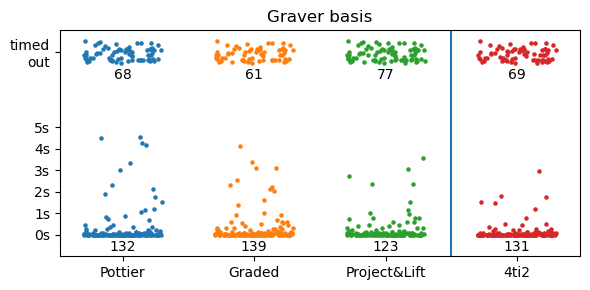

In [52]:
def remap(s): 
    return name_map[s] if s in name_map else s
# vecs = [np.array(new_list[c]) for c in col_names]
fig,axes = plt.subplots(1,1, figsize=(6, 3))
# fig,axes = plt.subplots(1,3, figsize=(12, 3), width_ratios=[4,3,2])
y_tout = 8
xx = (np.random.rand(len(data)) - 0.5) * 0.6
yy = np.random.rand(len(data)) + y_tout
for jj in [2]:#range(3):
    prefix = {0:('Hil', 'Hilbert basis'), 1:('Ray', 'Extremal rays'), 2:('Gra', 'Graver basis')}
    ax = axes
    jj_col_names = [c for c in col_names if c.startswith(prefix[jj][0])]
    for i, col_name in enumerate(jj_col_names):
        vv = np.array(data[col_name])
        num_tout = np.sum(vv<0)
        vv[vv<0] = yy[vv<0]
        ax.scatter(xx+i, vv, s=5)
        ax.text(i, y_tout-.75, f'{num_tout}', fontsize=10, ha='center')
        ax.text(i, -.75, f'{len(vv)-num_tout}', fontsize=10, ha='center')
    ax.set_title(prefix[jj][1])
    
    ax.set_xticks(range(len(jj_col_names)), [remap(c.split('_')[1]) for c in jj_col_names])
    ax.set_yticks(list(range(6))+[y_tout+.5], [f'{s}s' for s in list(range(6))]+['timed\nout'])
    ax.vlines(i-.5, -1, y_tout+2) 
    ax.set_ylim(-1, y_tout+1.5)
plt.tight_layout()
plt.savefig(f'{model_list_name}-time.pdf', bbox_inches='tight')
plt.show()

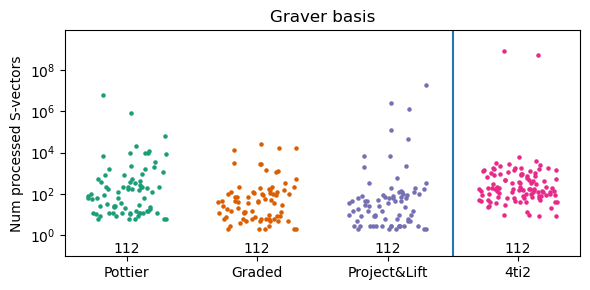

In [53]:
from matplotlib  import colormaps
cmap = colormaps['Dark2']
fig,axes = plt.subplots(1,1, figsize=(6, 3))
# fig,axes = plt.subplots(1,3, figsize=(12, 3), width_ratios=[4,3,2])
for jj in [2]: #range(3):
#     if jj==1: continue
    prefix = {0:('Hil', 'Hilbert basis'), 1:('Ray', 'Extremal rays'), 2:('Gra', 'Graver basis')}
    ax = axes
    jj_col_names = [c for c in col_names if c.startswith(prefix[jj][0])]# and not '4ti2' in c]
    NL = data.copy()
    y_tout = 1
    for n in jj_col_names:
        NL = NL[ NL[n+'_C'] != -1 ]
    for n in jj_col_names:
        y_tout = max(y_tout, int(NL[n+'_C'].max()))
    y_tout *= 10
    xx = (np.random.rand(len(NL)) - 0.5) * 0.6
    yy = np.random.rand(len(NL)) + y_tout
    for i, col_name in enumerate(jj_col_names):
        vv = np.array(NL[col_name])
        vC = np.array(NL[col_name+'_C'], dtype=int)
        tout_mask = vv<0
        num_tout = np.sum(tout_mask)
#         y_tout = 1e+15
        vC[tout_mask] = yy[tout_mask]
        vC[vC < 0] = 1
        ax.scatter(xx+i, vC, s=5, color=cmap(i))
#         ax.text(i, y_tout-.75, f'{num_tout}', fontsize=12, ha='center')
        ax.text(i, 0.15, f'{len(vv)-num_tout}', fontsize=10, ha='center')
    ax.set_title(prefix[jj][1])
    
    ax.set_xticks(range(len(jj_col_names)), [remap(c.split('_')[1]) for c in jj_col_names])
#     ax.set_yticks(list(range(6))+[y_tout+.5], [f'{s}s' for s in list(range(6))]+['timed\nout'])
    ax.vlines(i-.5, -1, y_tout+2) 
    ax.set_ylim(0.099, y_tout) 
    ax.set_yscale('log')
    ax.set_ylabel('Num processed S-vectors')
plt.tight_layout()
plt.savefig(f'{model_list_name}-svectors.pdf', bbox_inches='tight')
plt.show()

In [427]:
kA, kB = 'Hil_nL', 'Hil_nLH'
kAC, kBC = kA+'_C', kB+'_C'
print(f'{kB} better than {kA}:')
pd.options.display.float_format = '{:,.0f}'.format
data2 = data[(data[kAC]>=0) | (data[kBC]>=0)].copy()
data2[kAC] = data2[kAC].replace(-1, 1000000)
data2[kBC] = data2[kBC].replace(-1, 1000000)
data2[ data2[kAC] > 2*data2[kBC] + 1 ][['model', kA, kAC, kB, kBC]]

Hil_nLH better than Hil_nL:


,model,Hil_nL,Hil_nL_C,Hil_nLH,Hil_nLH_C
5,AutoFlight-PT-01b,0,15,0,6
59,FlexibleBarrier-PT-04a,0,5,0,0
84,MultiwaySync-PT-none,1,24,1,0
88,NoC3x3-PT-1A,1,39,1,0
119,Raft-PT-02,0,3,0,0
124,Referendum-PT-0015,0,14,0,0
152,ShieldIIPt-PT-002A,0,20,0,4
154,ShieldPPPs-PT-001A,0,13,0,4
157,ShieldPPPt-PT-001B,0,34,0,8
159,ShieldRVt-PT-001A,0,4,0,0


In [16]:
print('HNF better than IGE:')
data2[ data2.Hil_IGE_C > 2*data2.Hil_HNF_C + 1 ][['model', 'Hil_HNF', 'Hil_HNF_C', 'Hil_IGE', 'Hil_IGE_C']]

HNF better than IGE:


NameError: name 'data2' is not defined

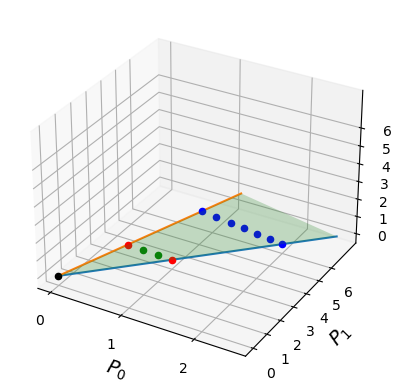

In [204]:
def make_3dplot(ax):
    ax.plot([0,2.5], [0,7.5], [0,0])
    ax.plot([0,2.5], [0,0], [0,7.5])

    ax.plot_trisurf(np.array([0, 2.5, 2.5]), 
                    np.array([0, 7.5, 0]),
                    np.array([0, 0, 7.5]), alpha=.25)
    ax.scatter3D([0], [0], [0], c='black')
    ax.scatter3D([1], [3], [0], c='r')
    ax.scatter3D([1], [0], [3], c='r')
    ax.scatter3D([1], [1], [2], c='g')
    ax.scatter3D([1], [2], [1], c='g')

    ax.scatter3D([2], [2], [4], c='b')
    ax.scatter3D([2], [4], [2], c='b')
    ax.scatter3D([2], [1], [5], c='b')
    ax.scatter3D([2], [5], [1], c='b')
    ax.scatter3D([2], [6], [0], c='b')
    ax.scatter3D([2], [0], [6], c='b')
    ax.scatter3D([2], [3], [3], c='b')

    ax.set_xlabel('$P_0$', fontsize=14)
    ax.set_ylabel('$P_1$', fontsize=14)
    ax.set_zlabel('$P_2$', fontsize=14)

    ax.set_xticks(range(3))
    ax.set_yticks(range(7))
    ax.set_zticks(range(7))

ax = plt.figure().add_subplot(projection='3d')
make_3dplot(ax)

In [206]:
# Rotate the axes and update
for angle in tqdm(range(0, 360*4 + 1)):
    ax = plt.figure().add_subplot(projection='3d')
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

    # Cycle through a full rotation of elevation, then azimuth, roll, and all
    elev = azim = roll = 0
    if angle <= 360:
        elev = angle_norm
    elif angle <= 360*2:
        azim = angle_norm
    elif angle <= 360*3:
        roll = angle_norm
    else:
        elev = azim = roll = angle_norm

    # Update the axis view and title
    ax.view_init(elev, azim, roll)
    plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))
    make_3dplot(ax)

    # plt.draw()
    plt.savefig(f"video/image_{angle:03}.png")
    plt.close()
    # plt.pause(.001)

    # ffmpeg -framerate 24 -i video/image_%3d.png -r 10 -pix_fmt yuv420p video.mp4

  0%|          | 0/1441 [00:00<?, ?it/s]

100%|██████████| 1441/1441 [02:06<00:00, 11.37it/s]


In [428]:
swaps = [(3, 0), (6, 1), (11, 2), (12, 3), (13, 4), (14, 5), (16, 6), (17, 7), (18, 8), (19, 9), 
         (20, 10), (21, 11), (22, 12), (23, 13), (24, 14), (16, 15), (22, 16), (18, 17), (20, 18), 
         (23, 19), (24, 20), (24, 21), (24, 22), (23, 23), (24, 24)]
l = list(range(25))
for a,b in swaps:
    l[a], l[b] = l[b], l[a]
print(l)

[3, 6, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 1, 0, 8, 10, 4, 5, 7, 2, 9, 15]


# Problem shuffle

In [506]:
with open('mats_basic/55.mat', 'r') as f:
    nr, nc = [int(x) for x in f.readline().split()]
    A = np.zeros([nr, nc], dtype=int)
    for i in range(nr):
        data = [int(x) for x in f.readline().split()]
        for j in range(nc):
            A[i,j] = data[j]
# print(nr, nc)
# print(A)

#randomly shuffle columns of A
for k in range(100):
    j1 = np.random.randint(nc)
    j2 = np.random.randint(nc)
    c1 = A[:,j1].copy()
    c2 = A[:,j2].copy()
    A[:,j1] = c2 ; A[:,j2] = c1
# print(A)

with open('mats_basic/55shuffled.mat', 'w') as f:
    print(nr,nc, file=f)
    for i in range(nr):
        for j in range(nc):
            print(A[i,j], end=' ', file=f)
        print('', file=f)
